# `Chinook Music Store`
The Chinook Records Store Database serves as a comprehensive blueprint for a digital music store, containing intricate details regarding artists, music, songs, albums, customers, and purchases. It functions akin to a condensed version of iTunes, meticulously organizing information into eleven tables. This resource is invaluable for both music enthusiasts and data aficionados, providing deep insights into the operational dynamics of a music store.
![Image description](images/img.jpeg)


In [2]:
#importing libraries
import pandas as pd
import sqlite3 as sql
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [3]:
db = "chinook.db"
def run_query(q):
    with sql.connect(db) as conn:
        return pd.read_sql_query(q, conn)

#### `General Analysis for album selection: Identifying Top Selling Genres in USA`
Chinook record store wants to select three albums from a list of four new artists, each belonging to different genres. The genres include Hip-Hop, Punk, Pop, and Blues.The record label focuses on US artists and plans to advertise in USA.

| Artist Name          | Genre   |
|----------------------|---------|
| Regal                | Hip-Hop |
| Redtone              | Punk    |
| Meteor And The Girls | Pop     |
| Slim Jim Bites       | Blues   |

To decide which album to choose, we need to find out which genre is the most popular in USA. We'll do this by querying the database to see which genres sell the most tracks in USA. Based on this information, we'll make recommendations for the three artists whose albums Chinook should purchase.


In [4]:
q = """
   WITH usa_tracks AS
(
    SELECT t.genre_id as genre_id, il.invoice_line_id
    FROM track as t
    INNER JOIN invoice_line as il on il.track_id = t.track_id
    INNER JOIN invoice as i ON i.invoice_id = il.invoice_id
    WHERE i.billing_country = "USA"
)
SELECT g.name as genre_name,
       COUNT(usa.genre_id) as num_purchases,
       ROUND(CAST(COUNT(usa.genre_id) as float) / (SELECT COUNT(*) FROM usa_tracks) * 100, 2) as percentage_sold
FROM usa_tracks as usa
INNER JOIN genre as g ON g.genre_id = usa.genre_id
GROUP BY g.name
ORDER BY num_purchases DESC;

    """
df = run_query(q)
df

,genre_name,num_purchases,percentage_sold
0,Rock,561,53.38
1,Alternative & Punk,130,12.37
2,Metal,124,11.80
3,R&B/Soul,53,5.04
4,Blues,36,3.43
5,Alternative,35,3.33
6,Pop,22,2.09
7,Latin,22,2.09
8,Hip Hop/Rap,20,1.90
9,Jazz,14,1.33


C:\Users\User\AppData\Local\Temp\ipykernel_13952\1730968841.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(df["genre_name"],fontsize= 10.5,color= "grey")


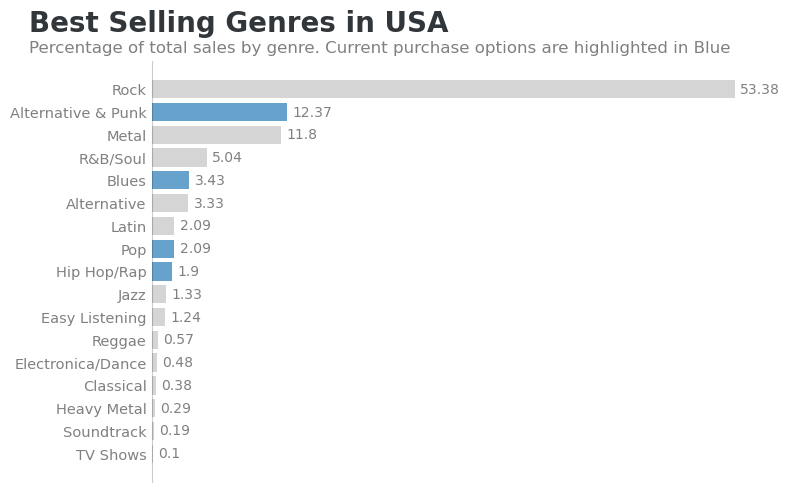

In [5]:
#sorting the dataframe by percentage sold
df= df.sort_values(by="percentage_sold")

#creating a color map to identify key albums of interest
album_options = ["Hip Hop/Rap","Alternative & Punk", 'Blues','Pop']
cmap = df['genre_name'].apply(lambda x: '#0064AB' if x in album_options else '#BABABA')

#Creating the bar plot
fig, ax= plt.subplots(figsize=(8,5))
bars = ax.barh(df['genre_name'], df['percentage_sold'], height = 0.8, color = cmap, alpha = 0.6)

#Adding text and adjusting width of bars
for bar, percentage in zip(bars,df['percentage_sold']):
    ax.text(bar.get_width()+0.5,bar.get_y()+bar.get_height()/2,f'{percentage}',va = 'center',ha = 'left',fontsize=10,color = 'grey')

#customizing axes and layout
ax.set_yticklabels(df["genre_name"],fontsize= 10.5,color= "grey")
ax.set_xticks([])
plt.text(-0.2,1.07,"Best Selling Genres in USA",fontsize = 20,fontweight ='bold',color = '#31363b',transform = plt.gca().transAxes)
plt.text(-0.2,1.02,"Percentage of total sales by genre. Current purchase options are highlighted in Blue",fontsize=12,color = 'grey',transform =plt.gca().transAxes)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

#adjusting left spine opacity
ax.spines['left'].set_color('#000000')
ax.spines['left'].set_alpha(0.2)

#removing y-axis tick parameters
ax.tick_params(axis ='y',which='both',length=0)

plt.tight_layout()
plt.show()

#### `Results`
>Based on the genre sales pattern in the USA. Chinook should select these options from the list of available albums.
>- **Punk:** Red Tone
>- **Blues:** Slim Jim Bites
>- **Pop:** Meteor And The Girls

>It's worth nothing that these three genres only make up **17%** of total sales. To maximize profitability, the company should be on the lookout for Rock songs since they account for **53%** of sales in the US market.

### `Employee Sales Performance Analysis`
#### `The Situation`
After an initial purchase, each chinook customer is assigned to a sales support agent. The company asked us to analyze purchases from customers belonging to each sales agent. They want to know if some agents are performing better or worse than others.

#### `Analysis`
To answer this question, we need to extract the names of sales executives, their hire dates, the number of accounts they handle, and the total purchases made by these accounts. We will also compute the average sales for each account that the sales executive manage.

In [7]:
q = """
WITH T1 as (
select em.first_name || " " || em.last_name as sales_rep_name, em.hire_date,
COUNT(cu.customer_id) as num_invoices, CAST(SUM(iv.total) AS INTEGER)AS total_sales
FROM employee em
JOIN customer cu
ON em.employee_id=cu.support_rep_id
JOIN invoice iv
ON iv.customer_id=cu.customer_id
GROUP BY 1
ORDER BY 4 DESC
)
SELECT *, ROUND(CAST(total_sales as float )/num_invoices,2) as sales_per_customer
from T1;
"""
df = run_query(q)
df

,sales_rep_name,hire_date,num_invoices,total_sales,sales_per_customer
0,Jane Peacock,2017-04-01 00:00:00,212,1731,8.17
1,Margaret Park,2017-05-03 00:00:00,214,1584,7.40
2,Steve Johnson,2017-10-17 00:00:00,188,1393,7.41


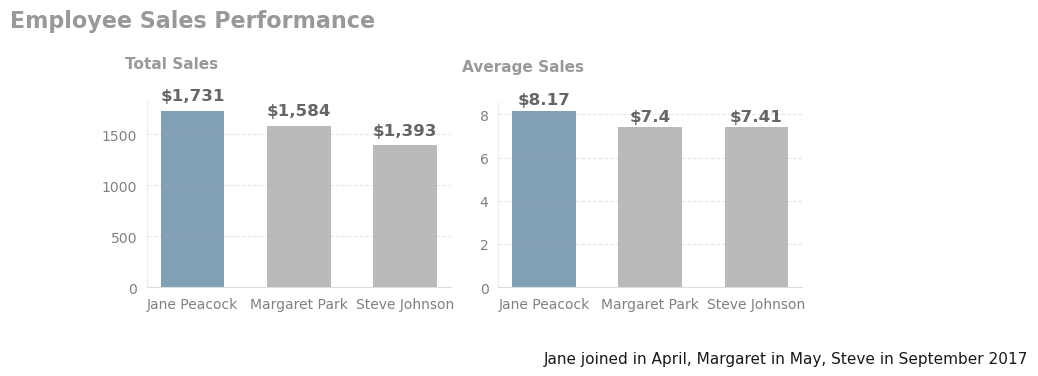

In [8]:
#Data
sales_rep_name = df["sales_rep_name"].values
total_sales = df["total_sales"].values
sales_per_customer = df["sales_per_customer"].values

#Create subplots
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(10,8))

#Total sales chart
axes[0].bar(sales_rep_name,total_sales,color="#BABABA",width=0.6)
axes[0].bar(sales_rep_name[0],total_sales[0],color="#0064AB",alpha=0.3,width=0.6)

#Total sales chart label
axes[0].text(x=-0.2,y=2150,s="Total Sales",size=11,fontweight="bold",alpha=0.4,ha="center")

#Total sales annotations
for sales,index in zip(total_sales,range(3)):
    axes[0].text(x=index,y=sales+100,s="${:,}".format(sales),ha="center",fontweight="bold",alpha=0.6,size=12)

# Main Chart title
axes[0].text(x=0,y=2550,s="Employee Sales Performance",size=16,fontweight="bold",alpha=0.4,ha="center")

#Average Sales chart
axes[1].bar(sales_rep_name,sales_per_customer,color="#BABABA",width=0.6)
axes[1].bar(sales_rep_name[0],sales_per_customer[0],color="#0064AB",alpha=0.3,width=0.6)

#Average sales chart label
axes[1].text(x=-0.2,y=10,s="Average Sales",size=11,fontweight="bold",alpha=0.4,ha="center")

#Average sales annotations
for sales,index in zip(sales_per_customer,range(3)):
    axes[1].text(x=index,y=sales+0.3,s="${:,}".format(sales),ha="center",fontweight="bold",alpha=0.6,size=12)
    
#Footnote
axes[1].text(x=0,y=-3.5,s="Jane joined in April, Margaret in May, Steve in September 2017",size=11,alpha=0.9)

#Common attributes to both charts
for ax in axes:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_color("#DDD")
    ax.spines["left"].set_alpha(0.5)
    ax.spines["bottom"].set_color("#DDD")
    ax.spines["top"].set_alpha(0.5)
    
    ax.tick_params(left=False,bottom=False,labelsize=10,labelcolor="grey")
    ax.grid(axis='y',linestyle="--",alpha=0.3)
    
plt.tight_layout(rect=[0,0.03,1,0.95])
plt.show()

#### `Results`
>
>- Of the three sales employees, Jane acheived the highest total sales of **1,731 dollars**. Margaret Park comes second, and Steve occupies the last place with **1,393 dollars** in sales. This difference in sales is understandable, considering that Jane and Margaret were employed about five months before Steve.
>- Jane's average sales number supports her leading position. She has acheived **8.17 dollars** in sales per customer, the highest of the three employees. Steve also performs marginally better than Margaret despite the difference in their employment dates.

### `Sales by Country`

#### `The Situation`
Chinook wants to understand how sales are distributed across different counteries. The company intends to identify counteries with growth potential and may even run adverstising campaigns in these counteries

#### `Analysis` 
To answer this question, we will write a query that collates data on these purchases from different counteries. For each country, we will include the total number of customers, total sales value, average sales per customer, and the average order value. Where a country has only one customer, we will collect it into an "Other" group.

In [9]:
q="""
    --Collate the number of customers in each country
    WITH t1 as (SELECT country, COUNT(customer_id) as num_customers
    FROM customer
    GROUP BY country
    ),
    
    --collate the total sales in each country
    t2 as( SELECT cu.country, ROUND(SUM(iv.total),2) AS total_sales, COUNT(iv.invoice_id) as num_sales
    FROM customer cu
    JOIN invoice iv on cu.customer_id=iv.customer_id
    GROUP BY 1
    ),
    
    --Group countries with only 1 customer as "Others"
    t3 as ( Select CASE WHEN t1.num_customers = 1 THEN "Others"
                        ELSE t1.country END as countries,
                        SUM(t1.num_customers) as num_customers,
                        SUM(t2.total_sales) as total_sales,
                        SUM(t2.num_sales) as num_sales
                    From t1 JOIN t2 on t1.country=t2.country
                    Group BY 1
    )
    
    --Calculate relevant sales metrics
    SELECT countries, num_customers,total_sales,
    ROUND(total_sales/num_sales,2) as avg_order_value,
    ROUND(total_sales/num_customers,2) as sales_per_customer
    FROM(
    SELECT *, 
    CASE WHEN countries="Others" THEN 1
    ELSE 0 END as sort
    FROM t3
    )
    ORDER BY sort, num_customers DESC;
"""
df = run_query(q)
df

,countries,num_customers,total_sales,avg_order_value,sales_per_customer
0,USA,13,1040.49,7.94,80.04
1,Canada,8,535.59,7.05,66.95
2,Brazil,5,427.68,7.01,85.54
3,France,5,389.07,7.78,77.81
4,Germany,4,334.62,8.16,83.66
5,United Kingdom,3,245.52,8.77,81.84
6,Czech Republic,2,273.24,9.11,136.62
7,India,2,183.15,8.72,91.58
8,Portugal,2,185.13,6.38,92.57
9,Others,15,1094.94,7.45,73.00


In [10]:
#Additional calculations
avg_cust_purchase = df.sales_per_customer.mean()
print(avg_cust_purchase)
df["pcent_customer"]  = round(100*df.num_customers / df.num_customers.sum(),1)
df["pcent_sales"] = round(100*df.total_sales/df.total_sales.sum(),1)
df["cust_purchase_diff"] = round(100*(df.sales_per_customer-avg_cust_purchase)/avg_cust_purchase,2)

86.96100000000001


In [11]:
df

,countries,num_customers,total_sales,avg_order_value,sales_per_customer,pcent_customer,pcent_sales,cust_purchase_diff
0,USA,13,1040.49,7.94,80.04,22.0,22.1,-7.96
1,Canada,8,535.59,7.05,66.95,13.6,11.4,-23.01
2,Brazil,5,427.68,7.01,85.54,8.5,9.1,-1.63
3,France,5,389.07,7.78,77.81,8.5,8.3,-10.52
4,Germany,4,334.62,8.16,83.66,6.8,7.1,-3.80
5,United Kingdom,3,245.52,8.77,81.84,5.1,5.2,-5.89
6,Czech Republic,2,273.24,9.11,136.62,3.4,5.8,57.10
7,India,2,183.15,8.72,91.58,3.4,3.9,5.31
8,Portugal,2,185.13,6.38,92.57,3.4,3.9,6.45
9,Others,15,1094.94,7.45,73.00,25.4,23.2,-16.05


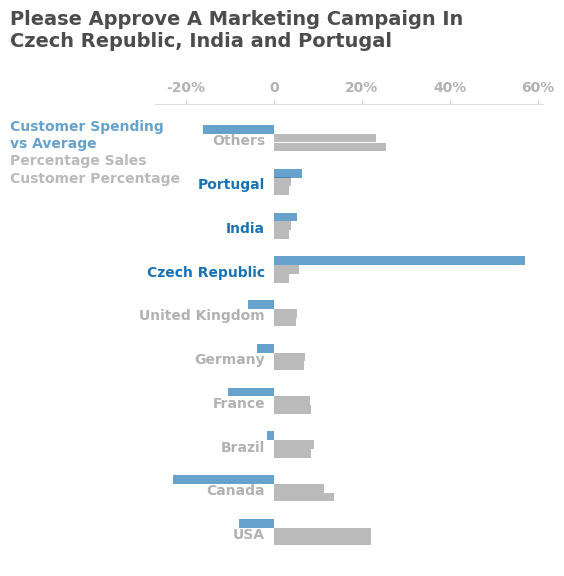

In [12]:
#visualization
y_labs = df.countries.values
y_axes = np.arange(df.countries.size)

fig=plt.figure(figsize=(5,6))
plt.barh(y_axes-0.3, df.pcent_customer, height=0.2,color="#BABABA")
plt.barh(y_axes-0.1,df.pcent_sales,height=0.2,color="#BABABA")
plt.barh(y_axes+0.1,df.cust_purchase_diff,height=0.2,color="#0064AB",alpha=0.6)

color_map = ['','','','','','','Yes','Yes','Yes','']

#Annotate y-ticks
for loc,label,color in zip(y_axes,y_labs,color_map):
    if color=="Yes":
        plt.text(x=-2,y=loc-0.25,s=label,ha='right',color="#0064AB",alpha=0.9,size=10,fontweight='bold')
    else:
        plt.text(x=-2,y=loc-0.25,s=label,ha='right',alpha=0.3,size=10,fontweight='bold')
        
# Set plot legend
plt.text(x=-60,y=8.7,s='Customer Spending\nvs Average',color="#0064AB",size=10,alpha=0.6,fontweight='bold')
plt.text(x=-60,y=8.3,s='Percentage Sales',color="#BABABA",size=10,fontweight='bold')
plt.text(x=-60,y=7.9,s='Customer Percentage',color="#BABABA",size=10,fontweight='bold')

#Set plot title
plt.text(x=-60,y=11,s="Please Approve A Marketing Campaign In \nCzech Republic, India and Portugal",alpha=0.7,size=14
         ,fontweight='bold')
for ax in fig.get_axes():
    plt.sca(ax)
    sns.despine(left=True,bottom=True,top=False)
    ax.tick_params(left=False,bottom=False,color="#ddd")
    ax.xaxis.set_ticks_position('top')
    ax.spines['top'].set_color('#DDD')
    plt.yticks([])
    plt.xticks([-20,0,20,40,60], ['-20%','0','20%','40%','60%'], size=10,alpha=0.3,fontweight='bold')

#### `Results`
>
>- The majority of chinook sales arise from US and Canada. These two countries dominate in customer base as well as sales. However, customers spend lesser per invoice in these countries.
>- Although the **Czech Republic, Portugal, and India** record fewer customers and lesser sales values, customers spend more per invoice than in other countries. To increase revenue from these three markets, Chinook could run marketing campaigns to expand it's customer base.

Since the data from each country are relatively few, the initial marketing campaigns should be small. They should aim to collect and analyze customer data so that the right trends are confidently identified.

### `How many tracks never sell?`
To answer this question, we will have to distinguish between entire inventory of tracks in `track` table and the distinct instances of tracks from the `invoice line` table

In [14]:
q = """
With all_and_purchased as(
    Select t.track_id as all_tracks,il.track_id as purchased_tracks
    FROM track t
    LEFT JOIN invoice_line il ON il.track_id=t.track_id
)

select COUNT(DISTINCT a.all_tracks) total_tracks,
    COUNT(DISTINCT a.purchased_tracks) tracks_purchased,
    COUNT(DISTINCT a.all_tracks)-COUNT(DISTINCT a.purchased_tracks) as not_purchased,
    ROUND(COUNT(DISTINCT a.purchased_tracks)/ CAST(COUNT(DISTINCT a.all_tracks) as float),2) percent_purchased
FROM all_and_purchased as a;
"""
purchased=run_query(q)
purchased

,total_tracks,tracks_purchased,not_purchased,percent_purchased
0,3503,1806,1697,0.52


In [15]:
purchased = purchased.T
purchased=purchased.iloc[[1,2],0]
purchased_list=purchased.tolist()
#purchased_list

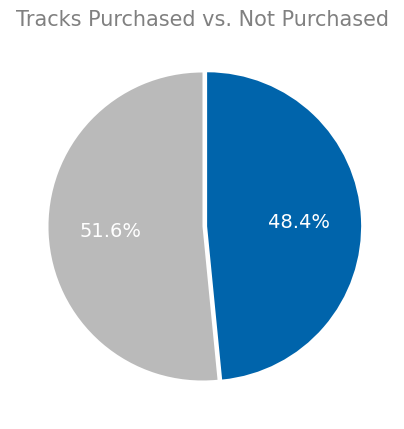

In [16]:
#Plot 
plt.pie(purchased_list,
       explode=(0,0.03),
       startangle=90,
        autopct="%1.1f%%",
        textprops={'fontsize':14,'color':'white'},
        colors=('#BABABA','#0064AB')
       )

#plot aesthetics
plt.title('Tracks Purchased vs. Not Purchased', fontsize=15,color='grey')
fig=plt.gcf()
fig.set_size_inches(5,5)
plt.show()

`Observations`
Surprisingly, almost half of the track inventory at Chinook has not sold. Let's take a look at the bottom performers and see of we can learn more:

In [18]:
q="""
SELECT ar.name artist_name,g.name genre,COUNT(il.track_id) units_sold
FROM track t
LEFT JOIN invoice_line il on il.track_id=t.track_id
INNER JOIN album al on al.album_id=t.album_id
INNER JOIN artist ar on ar.artist_id=al.artist_id
INNER JOIN genre as g on g.genre_id = t.genre_id
GROUP BY artist_name
HAVING units_sold=0
ORDER BY units_sold;
"""
run_query(q)

,artist_name,genre,units_sold
0,Aaron Copland & London Symphony Orchestra,Classical,0
1,Academy of St. Martin in the Fields Chamber En...,Classical,0
2,"Academy of St. Martin in the Fields, John Birc...",Classical,0
3,"Academy of St. Martin in the Fields, Sir Nevil...",Classical,0
4,Adrian Leaper & Doreen de Feis,Classical,0
...,...,...,...
69,The Office,TV Shows,0
70,The Tea Party,Alternative & Punk,0
71,Ton Koopman,Classical,0
72,Toquinho & Vinícius,Bossa Nova,0


#### `Observations`
74 artists have not sold any units, with most of these tracks belonging to the classical music genre.
Half of the company's inventory remains unsold, potentially tying up working capital without generating returns.
Depending on the payment arrangement with record labels, there are two scenarios to consider:
>
>1. If Chinook pays a fixed fee to host these tracks, it might be wise to focus on more popular genres and discontinue signing less successful artists

>2. If Chinook pays the record label based on sales percentage, there is little downside to keeping the tracks in the store.

Regardless of the scenario, Chinook should explore ways to promote these low-selling artists. Suggestions could be integrated into the purchasing process or displayed on the website's cart page to increase exposure

### `Albums vs. Individual Tracks`
The Chinook store allows customer to buy music in two ways: either as a complete album or as individual tracks. However, customers cannot buy a full album and then add individual tracks to the same purchase unless they select each track manually. When customers purchase albums, they are charged the same price as if they had bought each track separately.

Management is contemplating a new purchasing approach to cut costs. Instead of buying every track from an album, they are considering purchasing only the most popular tracks from each album from record companies.

In [19]:
q = """

with invoice_data as
(select invoice_id, track_id from invoice_line 
group by 1
),
album_purchased as
(select invoice_id,
case
    when(
    select t2.track_id from track t1 inner join track t2
    on t1.album_id = t2.album_id
    where t1.track_id=invd.track_id

    except
    
    select il.track_id from invoice_line il
    where il.invoice_id = invd.invoice_id
    ) is null
    AND(
    select il.track_id from invoice_line il
    where il.invoice_id = invd.invoice_id
        
    except
        
    select t2.track_id from track t1 inner join track t2
    on t1.album_id = t2.album_id
    where t1.track_id=invd.track_id
    ) is null
    then "Yes"
    else "No"
    end as Purchased_album
from invoice_data invd)

select Purchased_album,count(invoice_id) no_of_invoices, 
cast(count(invoice_id) as float) * 100/ (select count(invoice_id) from album_purchased) as percentage
from album_purchased
group by 1
"""
run_query(q)

,Purchased_album,no_of_invoices,percentage
0,No,500,81.433225
1,Yes,114,18.566775


#### `Results`
> Most purchases (81%) from the store are individual tracks. However, in about 19% of cases, customers buy entire albums. Chinook should be careful with purchasing only the most popular tracks since it risks loosing revenue from customers who purchase entire albums.

# `Conclusion and Recommendations`
Throughout this project, we have insights and recommendations to help a fictional company enhance it's profitability. By addressing various business scenarios, we've offered guidance on differenct aspects of the company's operations.

- **Genre Selection for New Albums :** Our analysis suggests that Chinook should prioritize genres with high popularity in USA. we recommend selecting albums from Hip-Hop, Punk, and Pop genres, as they show promising sales potential. Additionally, keeping an eye on Rock songs, which constitute the majority of the sales in the USA, could further boost the revenue.
- **Employee Performance:** Among the sales representatives, Jane Peacock stands as the top performer. While Steve Johnson appears to have lower total sales, it's important to note that he joined the team later than the others. Thus, he may require additional support and training to reach his full potential.
- **Sales Analysis by Country:** While the USA and Canada have the largest customer base, customers in these countries tends to spend less per transaction. On the other hand, the Czech Republic, India, and Portugal show higher average spending per customer. Launching targeted marketing campaigns in these regions could attract more customers and increase sales.
- **Track Purchasing Strategy:** Chinook's plan to focus solely on popular tracks may seem appealing, but it risks alienating customers who prefer to purchase entire albums. Conducting customer surveys and gathering feedback before implementing any changes would provide valuable insights into customer preferences.

In conclusion, by heading these recommendations and staying attuned to customer needs and market trends, Chinook can optimize it's operations, enhance customer satisfaction, and ultimately drive sustainable growth and profitability.